In [105]:
import sys
import os

import numpy as np 
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [215]:
cfg = {
    "lbl": "train_4_standard_best",
    "desc": "predicts point of size 4 from standard scaled train data",
    "data_suffix": "_standard",
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "betas": [0, 0.99],
    "lr": 1e-3,
    "batch_size": 125,
    "mini_batch_size": 410,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "metrics_freq": 10,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "num_pred_rows": 410,
    "num_reps": 10000,
    "finetune": True,
    "from_ckpt": True,
    "from_epoch": 2
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':1000,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_test'],
    'n_features':10,
    'n_informative':10,
    'n_targets':1,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [216]:
def make_sin_step(cfg):
    n_samples = cfg['n_samples_train']\
                +cfg['n_samples_test']
    rng = np.random.RandomState(0)
    X = rng.randn(n_samples, 2)
    noise = rng.normal(loc=0.0, scale=0.01, size=n_samples)
    y = 5 * X[:, 0] + np.sin(10 * np.pi * X[:, 0]) - noise
    return X, y

In [162]:
X_train, X_test, y_train, y_test = train_test_split(*make_sin_step(cfg_dataset),
                                                    test_size=cfg_dataset["n_samples_test"])
y_train = y_train[:, None]
y_test = y_test[:, None]

train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"])

lin_reg = LinearRegression()
_ = lin_reg.fit(X_train, y_train)

In [163]:
linear_NN = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)
opt = Adam(linear_NN.parameters(), lr=1e-3)
n_epoch = 10000
l2 = nn.MSELoss()

for i in range(n_epoch):
    opt.zero_grad()
    loss = l2(linear_NN(torch.Tensor(X_train)), torch.Tensor(y_train))
    loss.backward()
    
    opt.step()

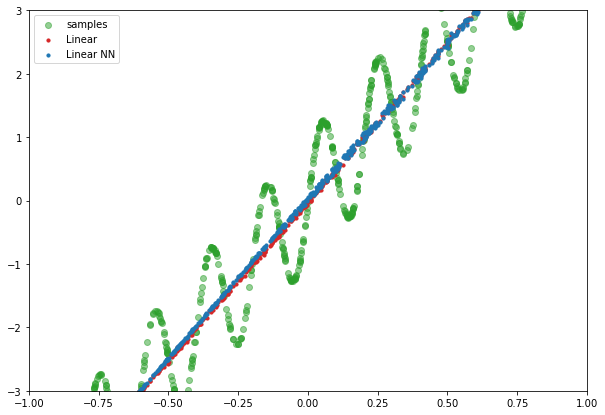

In [164]:
plt.figure(figsize=(10, 7))

plt.scatter(X_train[:, 0], y_train, alpha=0.5, zorder=-1, label="samples", color="tab:green")
plt.scatter(X_train[:, 0], lin_reg.predict(X_train), s=10, alpha=1, zorder=-1, label="Linear", color="tab:red")

with torch.no_grad():
    plt.scatter(X_train[:, 0], linear_NN(torch.Tensor(X_train)).numpy(), s=10, alpha=1, zorder=-1, label="Linear NN", color="tab:blue")

plt.ylim(-3, 3)
plt.xlim(-1, 1)

plt.legend()
plt.show()

### GAN Regression

$$
p(y|x) = (y|x) = NN([z,x]), C(y|x) = \text{NN}([y, x])
$$

In [240]:
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 5),
    nn.ReLU(),
    nn.Linear(5, y_train.shape[1])
)

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 20),
    nn.ReLU(),
    nn.Linear(20, y_train.shape[1])
)

optimG = Adam(netG.parameters(), lr=1e-2)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

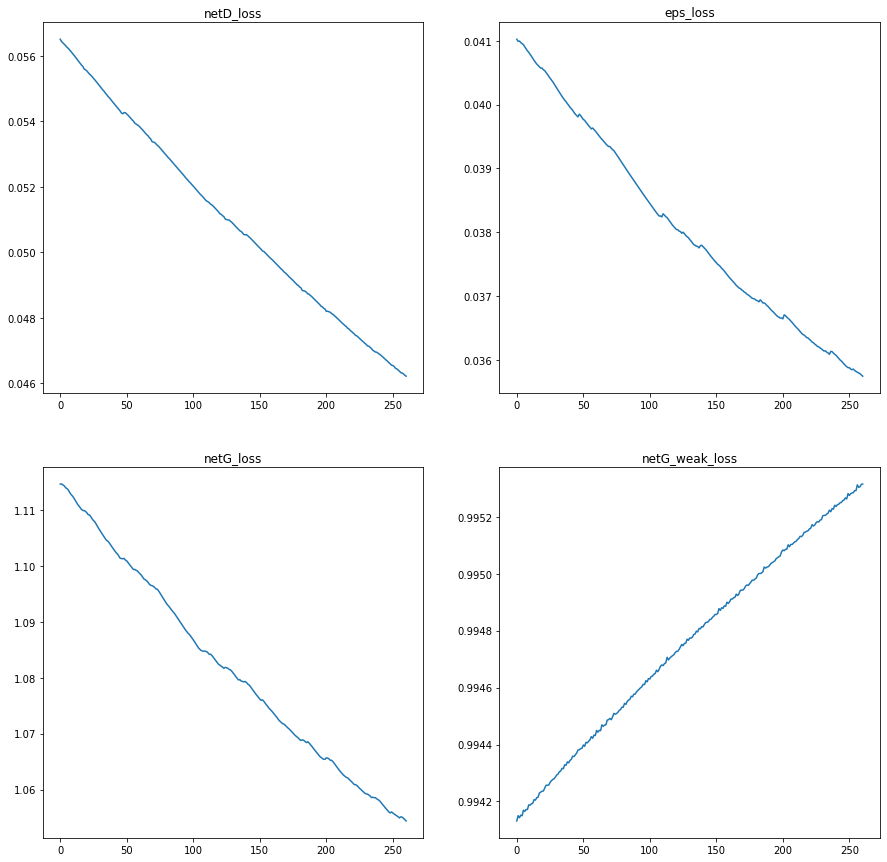

In [ ]:
try:
    losses = [[], [], [], []]

    for e in range(cfg['num_epochs']):
        for X_batch, y_batch in train_loader:
            optimD.zero_grad()
            real = torch.concat([X_batch.to(cfg['device']), y_batch.to(cfg['device'])], axis=1)

            with torch.no_grad():
                noise = torch.concat([X_batch.to(cfg['device']),
                                      torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
                fake = torch.concat([X_batch.to(cfg['device']),
                                     netG(noise)], axis=1)

            e_fake = netD(fake).mean()
            e_real = netD(real).mean()

            netD_loss = e_fake - e_real

            meters['netD_real_loss'].update(e_real.item())
            meters['netD_fake_loss'].update(e_fake.item())

            eps_pen = e_real ** 2
            eps_loss = eps_pen.mean()
            meters['eps_loss'].update(eps_loss.item())

            mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
            mixed = mix_alpha * real + (1 - mix_alpha) * fake
            mixed.requires_grad_(True)
            mixed_preds = netD(mixed).sum()
            grads = torch.autograd.grad(
                outputs=mixed_preds,
                inputs=mixed,
                create_graph=True,
                retain_graph=True,
            )[0]
            grads = grads.view(len(real), -1)
            grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
            meters['grad_loss'].update(grad_loss.item())

            netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
            meters['netD_loss'].update(netD_total_loss.item())
            netD_total_loss.backward()
            optimD.step()

            optimG.zero_grad()
            optimD.zero_grad()
            fake = torch.concat([X_batch.to(cfg['device']),
                                     netG(noise)], axis=1)

            netG_pred = netD(fake)
            netG_loss = -netG_pred.mean()

            grad_loss = ((grads.norm(2, dim=-1)) ** 2).mean()
            with torch.no_grad():
                L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
                meters['netG_loss'].update(L2Loss.item())
            meters['netG_weak_loss'].update(grad_loss.item())

            #fake_weak = netG(X_batch_weak.requires_grad_(True))
            #grads = torch.autograd.grad(
            #    outputs=fake_weak.sum(),
            #    inputs=X_batch_weak,
            #    create_graph=True,
            #    retain_graph=True,
            #)[0]

            netG_loss_total = netG_loss
            netG_loss_total.backward()
            optimG.step()

        if not e % 10:
            clear_output(wait=True)
            losses[0].append(meters["netD_loss"].avg)
            losses[1].append(meters["eps_loss"].avg)
            losses[2].append(meters["netG_loss"].avg)
            losses[3].append(meters["netG_weak_loss"].avg)

            plt.figure(figsize=(15, 15))
            ax1 = plt.subplot(221)
            ax2 = plt.subplot(222)
            ax3 = plt.subplot(223)
            ax4 = plt.subplot(224)

            ax1.set_title("netD_loss")
            ax1.plot(losses[0])

            ax2.set_title("eps_loss")
            ax2.plot(losses[1])

            ax3.set_title("netG_loss")
            ax3.plot(losses[2])

            ax4.set_title("netG_weak_loss")
            ax4.plot(losses[3])

            plt.show()
except KeyboardInterrupt:
    clear_output(wait=True)
    losses[0].append(meters["netD_loss"].avg)
    losses[1].append(meters["eps_loss"].avg)
    losses[2].append(meters["netG_loss"].avg)
    losses[3].append(meters["netG_weak_loss"].avg)

    plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.set_title("netD_loss")
    ax1.plot(losses[0])

    ax2.set_title("eps_loss")
    ax2.plot(losses[1])

    ax3.set_title("netG_loss")
    ax3.plot(losses[2])

    ax4.set_title("netG_weak_loss")
    ax4.plot(losses[3])

    plt.show()

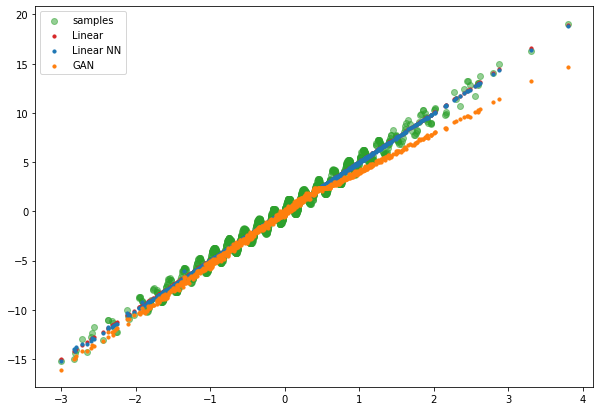

In [243]:
plt.figure(figsize=(10, 7))

plt.scatter(X_train[:, 0], y_train, alpha=0.5, zorder=-1, label="samples", color="tab:green")
plt.scatter(X_train[:, 0], lin_reg.predict(X_train), s=10, alpha=1, zorder=-1, label="Linear", color="tab:red")

with torch.no_grad():
    plt.scatter(X_train[:, 0], linear_NN(torch.Tensor(X_train)).numpy(), s=10, alpha=1, zorder=-1, label="Linear NN", color="tab:blue")
    
with torch.no_grad():
    noise = torch.concat([torch.Tensor(X_train).to(cfg['device']),
                          torch.randn(y_train.shape, device=cfg['device'])], axis=1)
    plt.scatter(X_train[:, 0], netG(noise), s=10, alpha=1, zorder=-1, label="GAN", color="tab:orange")

plt.ylim(-5, 5)
plt.xlim(-1, 1)

plt.legend()
plt.show()